# ** Tuberculosis Classifier**

 In this notebook, we will present the classification of chest X-ray images for Tuberculosis and normal patients . 

You will find more informations on the data used in this demenstration in the file DATA. 

We will use Xception,VGG16 and Mobilenet as our pretrained models for transfer learning.


In [ ]:
# Importing the libraries
import os
import sys
import random
import warnings
import numpy as np
import cv2
import pandas as pd 

import tensorflow as tf    
tf.random.set_seed(1234)
np.random.seed(1234)

from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D,Flatten,concatenate
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.keras.models import *

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications.xception import preprocess_input,Xception
from tensorflow.keras.applications import MobileNet

from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization,Dropout,Conv2DTranspose,LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.applications import MobileNetV2 ,InceptionV3

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.callbacks import *
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import *
# Importing the libraries

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools
from PIL import Image

import glob
from pathlib import Path

from tqdm import tqdm_notebook, tnrange
import tensorflow as tf

from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
init_notebook_mode(connected=True)


In [ ]:
import os 
from google.colab import drive 

drive.mount('/content/drive',force_remount=True)
os.chdir("/content/drive/My Drive")



Mounted at /content/drive


RESIZING AND **AUGMENTATION**

In [ ]:
#initializing parameters and directories
BATCH_SIZE =16
IMG_WIDTH = 128 
IMG_HEIGHT = 128 
IMG_CHANNELS = 3
seed = 120
train_dir='train/'
test_dir='test/'
val_dir='val/'

In [ ]:
def get_df(path):
    lst = []
    normal_dir = Path(path + "NORMAL")
    tb_dir = Path(path + "TB")
    normal_data = normal_dir.glob("*.png")
    tb_data = tb_dir.glob("*.png")
    for fname in normal_data:
        lst.append((fname, 0))
    for fname in tb_data:
        lst.append((fname, 1))
    df = pd.DataFrame(lst, columns=['Image', 'Label'], index=None)
    s = np.arange(df.shape[0])
    np.random.shuffle(s)
    df = df.iloc[s,:].reset_index(drop=True)
    return df

In [ ]:
df_train = get_df(train_dir)
df_val = get_df(val_dir)
df_test = get_df(test_dir)

In [ ]:
df_train.shape, df_val.shape, df_test.shape
df_train['Label'].value_counts()
df_train.shape, test_labels.shape


0    227
1    222
Name: Label, dtype: int64

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



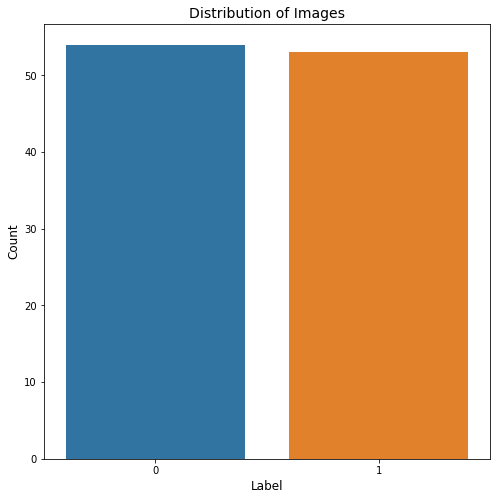

In [ ]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(8, 8))
sns.countplot(df_val['Label'])
ax.set_title('Distribution of Images', fontsize=14)
ax.set_xlabel('Label', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
plt.show()

# Data Augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.xception import preprocess_input

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator( rescale=1. / 255,rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    color_mode='rgb',
    target_size=(128,128),
    batch_size=16,
    class_mode='categorical',
)
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1. / 255)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    color_mode='rgb',
    target_size=(128,128),
    batch_size=16,
    class_mode='categorical',

)

test_generator=ImageDataGenerator(rescale=1. / 255)
test_generator=test_generator.flow_from_directory(test_dir,
    color_mode='rgb',
    target_size=(128,128),
    batch_size=16,
    class_mode='categorical',
 )

Found 449 images belonging to 2 classes.
Found 107 images belonging to 2 classes.
Found 235 images belonging to 2 classes.


# **Xception Model**

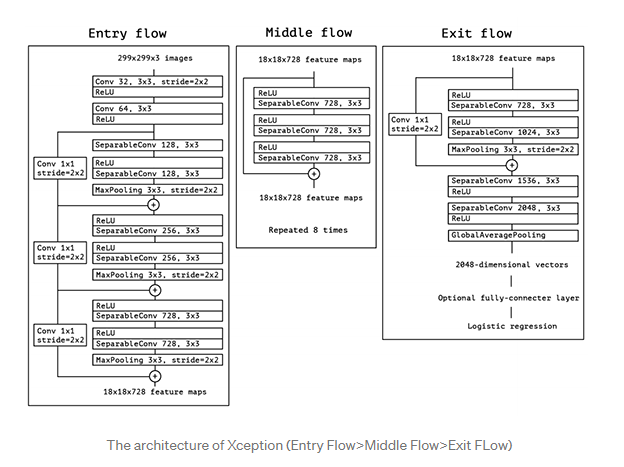

In [ ]:

    # Top Model Block
base_model = Xception(input_shape=(128, 128, 3), weights='imagenet', include_top=False)
x = base_model.output
x=GlobalAveragePooling2D()(x) #Flatten
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dropout(0.3)(x)
x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dropout(0.4)(x)
x=Dense(512,activation='relu')(x) #dense layer 3
x=Dropout(0.5)(x)

#x = GlobalAveragePooling2D()(x)
#x = Flatten()(x)
#x = Dense(100, activation='relu')(x)
#x = Dropout(0.4)(x)
#x = BatchNormalization()(x)

#x=GlobalAveragePooling2D()(x)
#x=Dense(100,activation='relu')(x) 
#x = Dropout(0.5)(x)
#x = BatchNormalization()(x)



#x = base_model.output
#x = GlobalAveragePooling2D()(x)
#x = Dense(64, activation='relu')(x)
#x = Dropout(0.2)(x)
#x = Dense(32, activation='relu')(x)


    # the output layer
predictions = Dense(2, activation='softmax')(x)#dense layer 3

    # add your top layer block to your base model
model = Model(base_model.input, predictions)
    # freezing all layers of the based model that is already pre-trained.
base_model.trainable = False
print(model.summary())



Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 63, 63, 32)   864         input_8[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 63, 63, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 63, 63, 32)   0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [ ]:

callbacks1 = [
    EarlyStopping(monitor='val_loss', patience=6, mode='min', verbose=1),
    ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 3, min_lr=0.00001, verbose=1, mode='min'),
    ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min'),
    ]

In [ ]:
import time
 #RMSprop  lr=0.001  epochs=10 
 #Adam BATCH=16

model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(lr= 0.001), metrics=["acc"])
start = time.time()


history = model.fit(
    train_generator,
    steps_per_epoch=449//16,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=107//16,
    callbacks = callbacks1
)

end = time.time()
print(end - start)

Epoch 1/20
28/28 [==============================] - 72s 2s/step - loss: 1.2455 - acc: 0.5391 - val_loss: 1.6611 - val_acc: 0.5000

Epoch 00001: val_loss improved from inf to 1.66112, saving model to best_model.h5
Epoch 2/20
28/28 [==============================] - 66s 2s/step - loss: 1.0362 - acc: 0.5677 - val_loss: 0.5821 - val_acc: 0.7083

Epoch 00002: val_loss improved from 1.66112 to 0.58211, saving model to best_model.h5
Epoch 3/20
28/28 [==============================] - 66s 2s/step - loss: 0.6745 - acc: 0.6508 - val_loss: 0.7175 - val_acc: 0.5104

Epoch 00003: val_loss did not improve from 0.58211
Epoch 4/20
28/28 [==============================] - 66s 2s/step - loss: 0.7030 - acc: 0.5817 - val_loss: 0.5663 - val_acc: 0.6562

Epoch 00004: val_loss improved from 0.58211 to 0.56634, saving model to best_model.h5
Epoch 5/20
28/28 [==============================] - 66s 2s/step - loss: 0.6589 - acc: 0.6216 - val_loss: 0.5131 - val_acc: 0.7500

Epoch 00005: val_loss improved from 0.56

FINE tuning

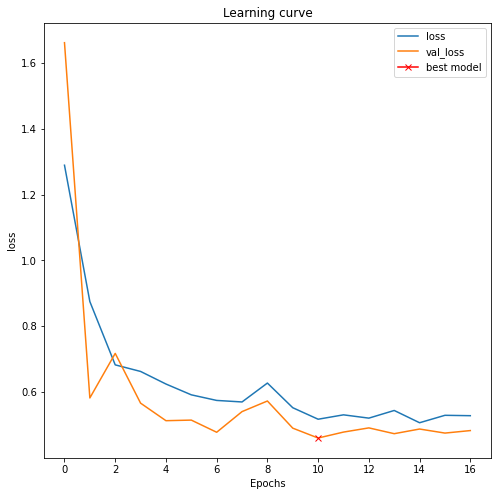

In [ ]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.plot( np.argmin(history.history["val_loss"]), np.min(history.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.legend();

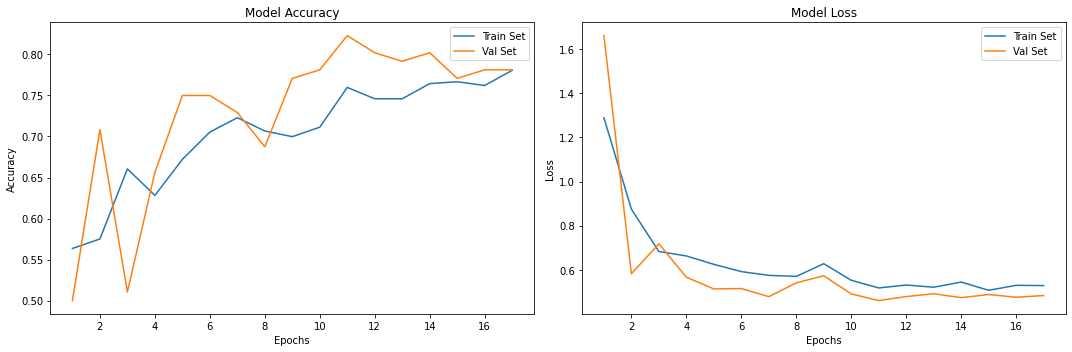

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [ ]:
# Evaluation on test dataset
test_loss, test_acc = model.evaluate(test_generator)
print("__Loss on test set:__ ", test_loss)
print("__Accuracy on test set:__ ", test_acc)


15/15 [==============================] - 39s 3s/step - loss: 0.5459 - acc: 0.7362
__Loss on test set:__  0.5459495782852173
__Accuracy on test set:__  0.73617023229599


Confusion Matrix


<Figure size 432x288 with 0 Axes>

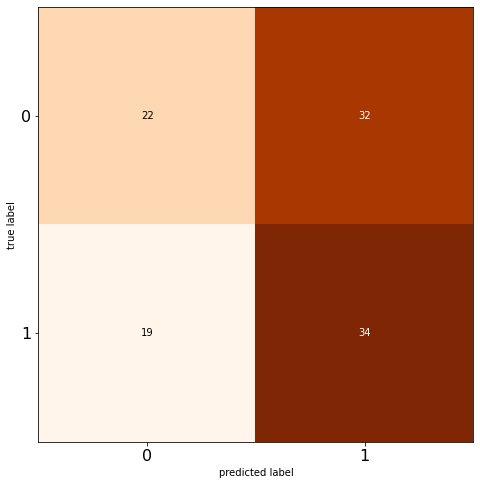

In [ ]:

from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
Y_pred = model.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm=confusion_matrix(validation_generator.classes, y_pred)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True, cmap=plt.cm.Oranges)
plt.xticks(range(2), fontsize=16)
plt.yticks(range(2), fontsize=16)
plt.show()

Confusion Matrix


<Figure size 432x288 with 0 Axes>

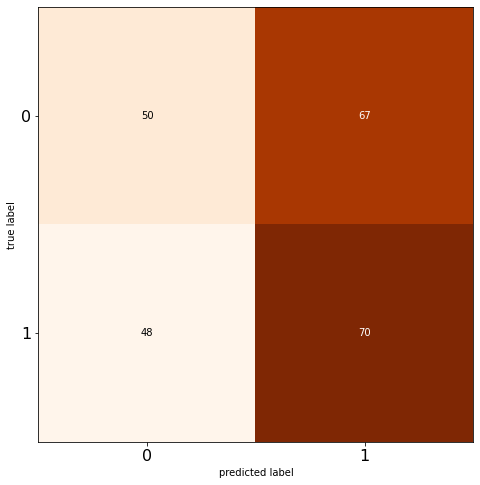

In [ ]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm=confusion_matrix(test_generator.classes, y_pred)
test_generator.classes
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True, cmap=plt.cm.Oranges)
plt.xticks(range(2),  fontsize=16)
plt.yticks(range(2),fontsize=16)
plt.show()

# **VGG16 Model**

In [ ]:
vgg = VGG16(input_shape= (128,128,3),weights='imagenet',include_top=False)
vgg.trainable = False
x = vgg.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024,activation='relu')(x)
x=Dropout(.5)(x)
x = Dense(1024,activation='relu')(x)
x=Dropout(.5)(x)
x = Dense(512, activation='relu')(x)
x=Dropout(.5)(x)
vggpreds = Dense(2,activation='softmax')(x)
model3 = Model(inputs = vgg.input,outputs=vggpreds)
model3.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0   

In [ ]:
import time
model3.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=["acc"])
start = time.time()


M3_history = model3.fit(
    train_generator,
    steps_per_epoch=449//16,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=107//16,
    callbacks = callbacks1
)

end = time.time()
print(end - start)

Epoch 1/10
28/28 [==============================] - 58s 2s/step - loss: 0.5895 - acc: 0.7171 - val_loss: 0.5286 - val_acc: 0.8125

Epoch 00001: val_loss did not improve from 0.45148
Epoch 2/10
28/28 [==============================] - 56s 2s/step - loss: 0.5726 - acc: 0.7092 - val_loss: 0.6992 - val_acc: 0.5521

Epoch 00002: val_loss did not improve from 0.45148
Epoch 3/10
28/28 [==============================] - 56s 2s/step - loss: 0.6172 - acc: 0.6831 - val_loss: 0.5646 - val_acc: 0.6458

Epoch 00003: val_loss did not improve from 0.45148
Epoch 4/10
28/28 [==============================] - 56s 2s/step - loss: 0.6284 - acc: 0.6579 - val_loss: 0.4748 - val_acc: 0.8542

Epoch 00004: val_loss did not improve from 0.45148
Epoch 5/10
28/28 [==============================] - 56s 2s/step - loss: 0.5724 - acc: 0.6649 - val_loss: 0.5324 - val_acc: 0.6979

Epoch 00005: val_loss did not improve from 0.45148
Epoch 6/10
28/28 [==============================] - 56s 2s/step - loss: 0.5631 - acc: 0.71

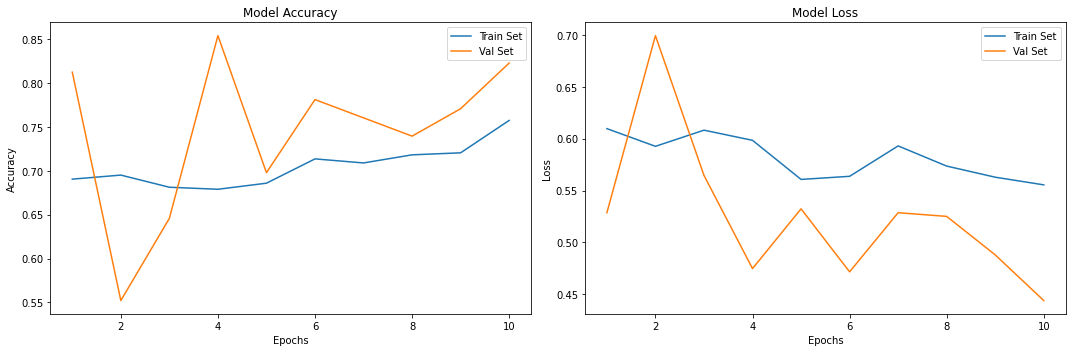

In [ ]:
acc = M3_history.history['acc']
val_acc = M3_history.history['val_acc']
loss = M3_history.history['loss']
val_loss = M3_history.history['val_loss']
epochs_range = range(1, len(M3_history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [ ]:
# Evaluation on test dataset
test_loss, test_acc = model3.evaluate(test_generator)
print("__Loss on test set:__ ", test_loss)
print("__Accuracy on test set:__ ", test_acc)


15/15 [==============================] - 33s 2s/step - loss: 0.4947 - acc: 0.7830
__Loss on test set:__  0.4947471022605896
__Accuracy on test set:__  0.7829787135124207


Confusion Matrix


<Figure size 432x288 with 0 Axes>

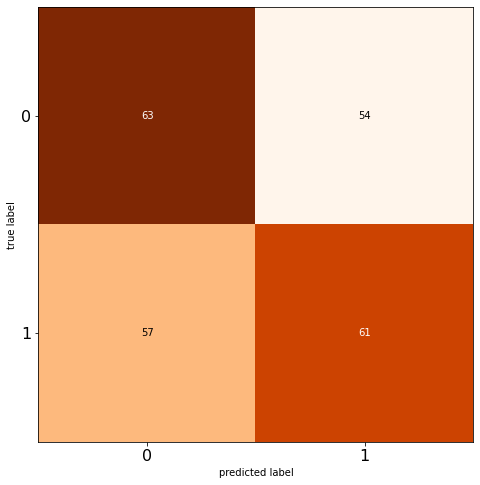

In [ ]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
Y_pred = model3.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm=confusion_matrix(test_generator.classes, y_pred)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True, cmap=plt.cm.Oranges)
plt.xticks(range(2),  fontsize=16)
plt.yticks(range(2), fontsize=16)
plt.show()

Confusion Matrix


<Figure size 432x288 with 0 Axes>

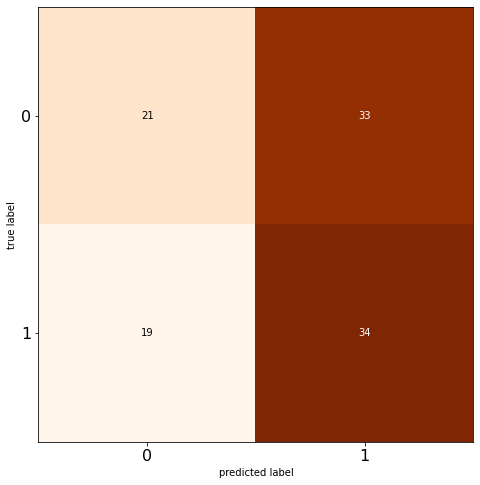

In [ ]:

from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
Y_pred = model3.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm=confusion_matrix(validation_generator.classes, y_pred)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True, cmap=plt.cm.Oranges)
plt.xticks(range(2), fontsize=16)
plt.yticks(range(2), fontsize=16)
plt.show()

# **MobileNet Model**

In [ ]:
base_model3=MobileNet(weights='imagenet',include_top=False) 

x=base_model3.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) 
x=Dropout(.5)(x)
x=Dense(1024,activation='relu')(x) 
x=Dropout(.3)(x)
x=Dense(512,activation='relu')(x) 
x=Dropout(.2)(x)
MNpreds = Dense(2,activation='softmax')(x)
model2 = Model(inputs = base_model3.input,outputs=MNpreds)
base_model3.trainable=False
model2.summary()


Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, None, None, 3)]   0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, None, 32)    864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, None, None, 32)    128       
_________________________________________________________________
conv1_relu (ReLU)            (None, None, None, 32)    0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)    288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, None, None, 32)    128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, None, None, 32)    0  

In [ ]:
import time
 #RMSprop  lr=0.001  epochs=10 Adam

model2.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=["acc"])
start = time.time()


M2history = model2.fit(
    train_generator,
    steps_per_epoch=449//16,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=107//16,)

end = time.time()
print(end - start)

Epoch 1/10
28/28 [==============================] - 59s 2s/step - loss: 2.0371 - acc: 0.4912 - val_loss: 0.6555 - val_acc: 0.6562
Epoch 2/10
28/28 [==============================] - 56s 2s/step - loss: 0.7440 - acc: 0.5476 - val_loss: 0.5625 - val_acc: 0.7188
Epoch 3/10
28/28 [==============================] - 56s 2s/step - loss: 0.6969 - acc: 0.6478 - val_loss: 0.7124 - val_acc: 0.5625
Epoch 4/10
28/28 [==============================] - 56s 2s/step - loss: 0.6693 - acc: 0.7026 - val_loss: 0.6295 - val_acc: 0.5833
Epoch 5/10
28/28 [==============================] - 56s 2s/step - loss: 0.6659 - acc: 0.6423 - val_loss: 0.6073 - val_acc: 0.6354
Epoch 6/10
28/28 [==============================] - 56s 2s/step - loss: 0.5652 - acc: 0.7337 - val_loss: 0.5566 - val_acc: 0.6875
Epoch 7/10
28/28 [==============================] - 56s 2s/step - loss: 0.5666 - acc: 0.7359 - val_loss: 0.4255 - val_acc: 0.8333
Epoch 8/10
28/28 [==============================] - 56s 2s/step - loss: 0.5237 - acc: 0.74

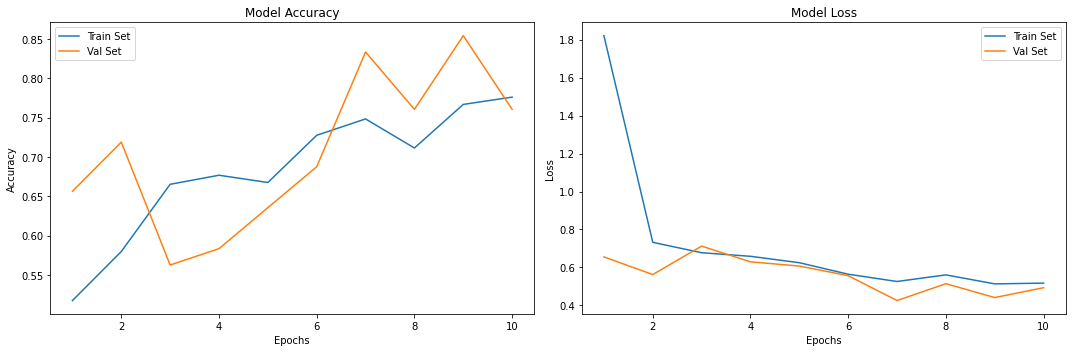

In [ ]:
acc = M2history.history['acc']
val_acc = M2history.history['val_acc']
loss = M2history.history['loss']
val_loss = M2history.history['val_loss']
epochs_range = range(1, len(M2history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [ ]:
# Evaluation on test dataset
test_loss,test_acc ,p,r= model2.evaluate(test_generator)
print("__Loss on test set:__ ", test_loss)
print("__Accuracy on test set:__ ", test_acc)


15/15 [==============================] - 35s 2s/step - loss: 0.4818 - acc: 0.7617 - precision: 0.7617 - recall: 0.7617
__Loss on test set:__  0.48179054260253906
__Accuracy on test set:__  0.7617021203041077


Confusion Matrix


<Figure size 432x288 with 0 Axes>

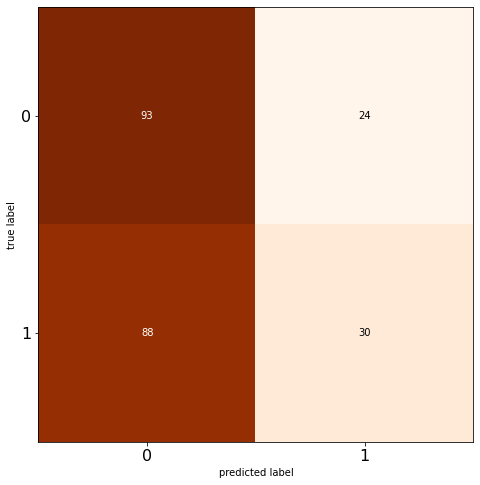

In [ ]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
Y_pred = model2.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm=confusion_matrix(test_generator.classes, y_pred)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True, cmap=plt.cm.Oranges)
plt.xticks(range(2),  fontsize=16)
plt.yticks(range(2), fontsize=16)
plt.show()

Confusion Matrix


<Figure size 432x288 with 0 Axes>

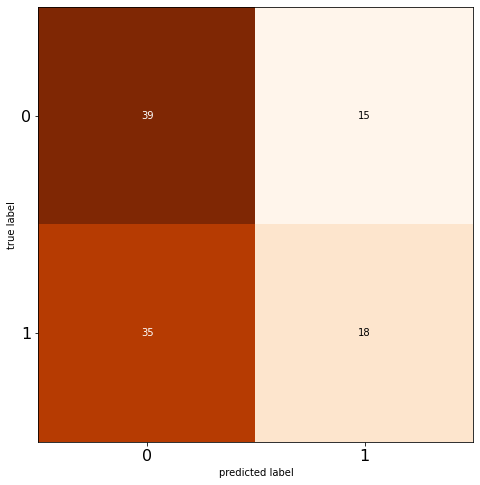

In [ ]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
Y_pred = model2.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm=confusion_matrix(validation_generator.classes, y_pred)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True, cmap=plt.cm.Oranges)
plt.xticks(range(2),  fontsize=16)
plt.yticks(range(2), fontsize=16)
plt.show()